notes on 2020.1.7:
- use linear rain rate instead of dBZ
- add T0 data, which is supposed to be 100% accurate for debugging

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
print(os.getcwd())

data_folder = "/Users/jiang/data/radar20190101"

/Users/jiang/github_all/rainymotion/docs/notebooks


## test rainymotion sparse mode, dense mode and persistence

In [2]:
from netCDF4 import Dataset
from datetime import datetime,timedelta
from rainymotion import models, metrics, utils
from collections import OrderedDict
import numpy as np
import h5py
import matplotlib.pyplot as plt
import wradlib.ipol as ipol
%matplotlib inline
from netCDF4 import Dataset

In [3]:
nc_files = glob.glob(os.path.join(data_folder,"*.nc"))  # 288 = 12*24
nc_files.sort()

In [4]:
all_data = [] # 288 arrays with shape (1000,1000)
for nc_file in nc_files:
    root = Dataset(nc_file, "r")
    rain = root['var0_1_203_surface'][0,:,:] # masked array, shape(3360,3560)
    rain_reduced = rain[1500:2500,1000:2000].copy()
    rain_reduced.fill_value = 0.0
    rain_filled = rain_reduced.filled()
    all_data.append(rain_filled) 

### text single prediction in 5,10,15..60 minutes 

In [6]:
now = 1
threshold = 1  # mm/h
threshold_5m = threshold / 12
if True: 
    hh = str(now * 5 // 60).zfill(2) 
    mm = str(now * 5  % 60).zfill(2)
    print(f"now = 2019.1.1-{hh}:{mm}")
    
    inputs = np.array([all_data[now-1],all_data[now]])
    
    # SparseSD mode
    model = models.SparseSD()
    model.input_data = inputs
    model.lead_steps = 13
    nowcast = model.run()  # shape (12, 900, 900)
    nowcast = nowcast/12  # convert mm/5min to mm/h
    
    sparse_13_th = []
    sparse_13_re = []
    sparse_13_pr = []
    for i in range (13):
        hits, misses, falsealarms, correctnegatives = metrics.prep_clf(all_data[now + i],nowcast[i], threshold = threshold_5m)
        sparse_13_th.append( hits / (hits + misses + falsealarms))
        sparse_13_re.append( hits / (hits + misses))
        sparse_13_pr.append( hits / (hits + falsealarms))
    
    # Dense mode
    model = models.Dense()
    model.input_data = inputs
    model.lead_steps = 13
    nowcast = model.run()  # shape (12, 900, 900)
    dense_13_th = []  # threat score
    dense_13_re = []  # recall
    dense_13_pr = []  # precision
    for i in range (13):
        hits, misses, falsealarms, correctnegatives = metrics.prep_clf(all_data[now + i],nowcast[i], threshold = threshold_5m)
        dense_13_th.append( hits / (hits + misses + falsealarms))
        dense_13_re.append( hits / (hits + misses))
        dense_13_pr.append( hits / (hits + falsealarms))
        #dense_12.append(metrics.CSI(all_data[now+1+i],nowcast[i], threshold = 1))

    # persistance    
    persist_13_th = []
    persist_13_re = []
    persist_13_pr = []
    for i in range (13):
        hits, misses, falsealarms, correctnegatives = metrics.prep_clf(all_data[now+i],all_data[now], threshold = threshold_5m)
        persist_13_th.append( hits / (hits + misses + falsealarms))
        persist_13_re.append( hits / (hits + misses))
        persist_13_pr.append( hits / (hits + falsealarms))

    plt.figure(dpi = 100)
    lead_time = list(range(0,65,5))
    plt.plot(lead_time, dense_13_th, '-*', label = "dense")
    plt.plot(lead_time, sparse_13_th, '-s',label = "sparse")
    plt.plot(lead_time, persist_13_th, '-o',label = "persistence")
    plt.legend()
    plt.ylim([0,1])
    plt.ylabel("threat score")
    plt.xlabel("minutes from now")
    plt.title(f"now = 2019.1.1-{hh}:{mm},rainymotion+opencv,threshold = 1 mm/h")
    plt.grid()
    plt.savefig("JMA_rainymotion_th" + str(now).zfill(3) + ".png",format = "png")
    plt.close()

now = 2019.1.1-00:05


### gif animation to display threat/recall/false alarm rate changes over in 5,10,15..60 minutes for 24 hours
- compare data using dBz or linear rain rate

In [20]:
from rainymotion.models import _advection_constant_vector, _calculate_of, _interpolator

In [21]:
class Dense_r:
    def __init__(self):
        self.input_data = None
        self.lead_steps = 12
        self.of_method = "DIS"
        self.direction = "backward"
        self.interpolation = "idw"
    def run(self):
        # scale input data to uint8 [0-255] with self.scaler
        c1 = self.input_data.min()
        c2 = self.input_data.max()
        scaled_data = ((self.input_data - c1) / (c2 - c1) * 255).astype(np.uint8)

        # calculate optical flow
        of = _calculate_of(scaled_data, method=self.of_method,direction=self.direction)

        # advect pixels accordingly
        coord_source, coord_targets = _advection_constant_vector(of, lead_steps=self.lead_steps)

        # nowcasts placeholder
        nowcasts = []

        # interpolation
        for lead_step in range(self.lead_steps):
            nowcasts.append(_interpolator(self.input_data[-1], coord_source,
                                          coord_targets[lead_step],
                                          method=self.interpolation))

        # reshaping
        nowcasts = np.moveaxis(np.dstack(nowcasts), -1, 0)

        return nowcasts

In [22]:
%%time
#now = 100
for now in range(1,270,12):  # every hour
    hh = str(now * 5 // 60).zfill(2) 
    mm = str(now * 5  % 60).zfill(2)
    print(f"now = 2019.1.1-{hh}:{mm}")
    
    inputs = np.array([all_data[now-1],all_data[now]])
    
    
    # Dense mode
    model = models.Dense()
    model.input_data = inputs
    nowcast = model.run()  # shape (12, 900, 900)
    dense_12_th = []  # threat score
    dense_12_re = []  # recall
    dense_12_pr = []  # precision
    for i in range (12):
        hits, misses, falsealarms, correctnegatives = metrics.prep_clf(all_data[now+1+i],nowcast[i], threshold = 1)
        dense_12_th.append( hits / (hits + misses + falsealarms))
        dense_12_re.append( hits / (hits + misses))
        dense_12_pr.append( hits / (hits + falsealarms))
        #dense_12.append(metrics.CSI(all_data[now+1+i],nowcast[i], threshold = 1))

    # using original linear data    
    model = Dense_r()
    model.input_data = inputs
    nowcast = model.run()  # shape (12, 900, 900)
    dense_12_th2 = []  # threat score
    dense_12_re2 = []  # recall
    dense_12_pr2 = []  # precision
    for i in range (12):
        hits, misses, falsealarms, correctnegatives = metrics.prep_clf(all_data[now+1+i],nowcast[i], threshold = 1)
        dense_12_th2.append( hits / (hits + misses + falsealarms))
        dense_12_re2.append( hits / (hits + misses))
        dense_12_pr2.append( hits / (hits + falsealarms))    
        
    plt.figure(dpi = 100)
    plt.plot(list(range(5,65,5)), dense_12_th, '-*', label = "dense")
    plt.plot(list(range(5,65,5)), dense_12_th2, '-s',label = "dense2")
    #plt.plot(list(range(5,65,5)), persist_12_th, '-o',label = "persistence")
    plt.legend()
    plt.ylim([0,1])
    plt.ylabel("threat score")
    plt.xlabel("minutes from now")
    plt.title(f"now = 2019.1.1-{hh}:{mm},rainymotion+opencv,threshold = 1 mm/h")
    plt.grid()
    plt.savefig("JMA_rainymotion_th" + str(now).zfill(3) + ".png",format = "png")
    plt.close()
    

now = 2019.1.1-00:05
now = 2019.1.1-01:05
now = 2019.1.1-02:05
now = 2019.1.1-03:05
now = 2019.1.1-04:05
now = 2019.1.1-05:05
now = 2019.1.1-06:05
now = 2019.1.1-07:05
now = 2019.1.1-08:05
now = 2019.1.1-09:05
now = 2019.1.1-10:05
now = 2019.1.1-11:05
now = 2019.1.1-12:05
now = 2019.1.1-13:05
now = 2019.1.1-14:05
now = 2019.1.1-15:05
now = 2019.1.1-16:05
now = 2019.1.1-17:05
now = 2019.1.1-18:05
now = 2019.1.1-19:05
now = 2019.1.1-20:05
now = 2019.1.1-21:05
now = 2019.1.1-22:05
CPU times: user 24min 1s, sys: 19.9 s, total: 24min 21s
Wall time: 4min 6s


In [15]:
import imageio
png_files = glob.glob("./JMA_rainymotion_th*.png")
png_files.sort()
print(len(png_files)) # 288

images = []
for filename in png_files:
    images.append(imageio.imread(filename))
output_file = 'JMA_rainymotion_threat-%s.gif' % datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
imageio.mimsave(output_file, images,duration = 1)  # unit is in seconds

23


In [16]:
import imageio
png_files = glob.glob("./JMA_rainymotion_re*.png")
png_files.sort()
print(len(png_files)) # 288

images = []
for filename in png_files:
    images.append(imageio.imread(filename))
output_file = 'JMA_rainymotion_recall-%s.gif' % datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
imageio.mimsave(output_file, images,duration = 1)  # unit is in seconds

23


In [18]:
import imageio
png_files = glob.glob("./JMA_rainymotion_pr*.png")
png_files.sort()
print(len(png_files)) # 288

images = []
for filename in png_files:
    images.append(imageio.imread(filename))
output_file = 'JMA_rainymotion_precision-%s.gif' % datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
imageio.mimsave(output_file, images,duration = 1)  # unit is in seconds

23


##  visualize the differece in gif
- RYScaler

In [21]:
from rainymotion import utils
data_scaled, c1, c2 = d(np.array(all_data))  # shape(288,1000,1000)
nowcast_scaled, c3,c4 = utils.RYScaler(np.array(nowcast))
data_rescaled= utils.inv_RYScaler(data_scaled,c1,c2)  # shape(288,1000,1000)

In [47]:
np.sum(image1>1)

27817

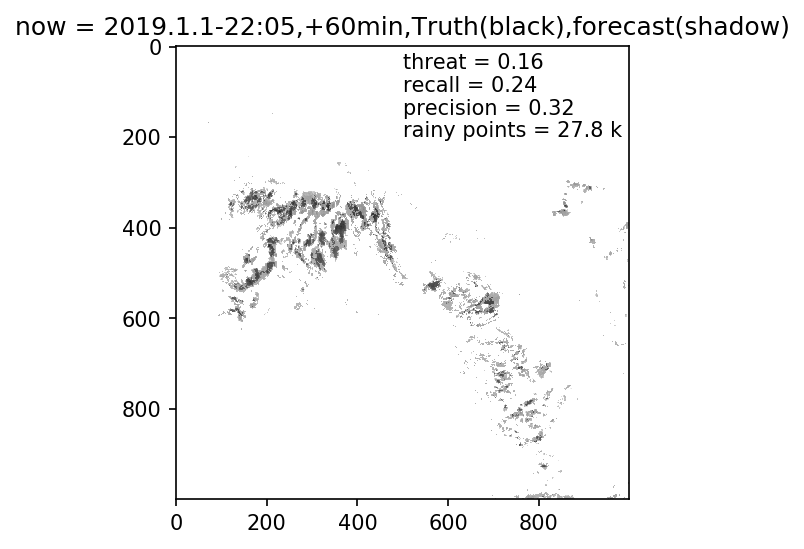

In [48]:
plt.figure(dpi = 150)
image1 = data_scaled[now+1+i]
image2 = nowcast_scaled[i]
plt.imshow(image1,cmap = 'gray_r')
plt.imshow(image2,cmap = 'gray_r',alpha = 0.5)
plt.title(f"now = 2019.1.1-{hh}:{mm},+{str(i*5+5).zfill(2)}min,Truth(black),forecast(shadow)")
plt.text(500, 50, f"threat = {dense_12_th[i]:.2f}")
plt.text(500, 100, f"recall = {dense_12_re[i]:.2f}")
plt.text(500, 150, f"precision = {dense_12_pr[i]:.2f}")
plt.text(500, 200, f"rainy points = {np.sum(image1>1)/1000:.1f} k")
plt.show()

In [49]:
for i in range(12):
    plt.figure(dpi = 150)
    image1 = data_scaled[now+1+i]
    image2 = nowcast_scaled[i]
    plt.imshow(image1,cmap = 'gray_r')
    plt.imshow(image2,cmap = 'gray_r',alpha = 0.5)
    plt.title(f"now = 2019.1.1-{hh}:{mm},+{str(i*5+5).zfill(2)}min,Truth(black),forecast(shadow)")
    plt.text(500, 50, f"threat = {dense_12_th[i]:.2f}")
    plt.text(500, 100, f"recall = {dense_12_re[i]:.2f}")
    plt.text(500, 150, f"precision = {dense_12_pr[i]:.2f}")
    plt.text(500, 200, f"rainy points = {np.sum(image1>1)/1000:.1f} k")
    plt.grid()
    plt.savefig("JMA_rainymotion_image_score" + str(i).zfill(2) + ".png",format = "png")
    plt.close()

In [50]:
import imageio
png_files = glob.glob("./JMA_rainymotion_image_score*.png")
png_files.sort()
print(len(png_files)) # 288

images = []
for filename in png_files:
    images.append(imageio.imread(filename))
output_file = 'JMA_rainymotion_image_score-%s.gif' % datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
imageio.mimsave(output_file, images,duration = 1)  # unit is in seconds

12


## check data distribution

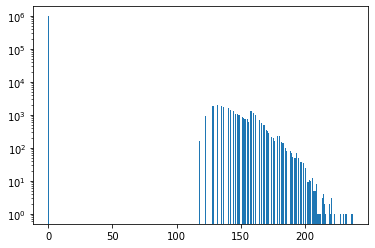

In [22]:
plt.hist(data_scaled[now+1+i].ravel(),256)
plt.yscale('log')

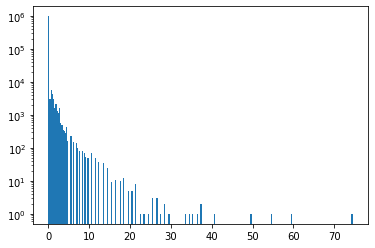

In [26]:
plt.hist(all_data[now+1+i].ravel(),256)
plt.yscale('log')

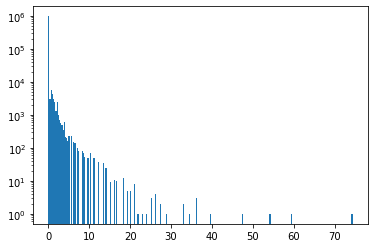

In [24]:
plt.hist(data_rescaled[now+1+i].ravel(),256)
plt.yscale('log')

In [28]:
np.mean(all_data[now+1+i]), np.mean(data_rescaled[now+1+i])

(0.053029694, 0.05174085478878213)

In [54]:
np.sum(all_data[now+1+i]==0),  np.sum(data_rescaled[now+1+i]==0)

(972183, 972183)

In [57]:
np.unique(all_data[now+1+i] )

array([ 0.  ,  0.35,  0.45,  0.55,  0.65,  0.75,  0.85,  0.95,  1.05,
        1.15,  1.25,  1.35,  1.45,  1.55,  1.65,  1.75,  1.85,  1.95,
        2.13,  2.38,  2.63,  2.88,  3.13,  3.38,  3.63,  3.88,  4.13,
        4.38,  4.63,  4.88,  5.25,  5.75,  6.25,  6.75,  7.25,  7.75,
        8.25,  8.75,  9.25,  9.75, 10.5 , 11.5 , 12.5 , 13.5 , 14.5 ,
       15.5 , 16.5 , 17.5 , 18.5 , 19.5 , 20.5 , 21.5 , 22.5 , 23.5 ,
       24.5 , 25.5 , 26.5 , 27.5 , 28.5 , 29.5 , 33.5 , 34.5 , 35.5 ,
       36.5 , 37.5 , 40.5 , 49.5 , 54.5 , 59.5 , 74.5 ], dtype=float32)

In [29]:
c1,c2

(0.0, 70.987785)